# Audit questions
- How well separated are our classes? If I search the 'journal article's do I find 'case-report' or some other obvious indicator of mis-classification?
- 

# Data munging
- ideally we dev/test on 2 datasets
  - case reports
  - an equal number of most-similar journal articles.
- this seems ideal for learning the key features.
- to get most-similar articles could require some extra step like tfidf/specter cosine similarity?

In [116]:
import os
import pandas as pd
import numpy as np

In [117]:
working_data_path = r'C:\Users\aday\OneDrive - SAGE Publishing\PROJECT_DATA\pubmed_case_report_classifier\data'
df_path = os.path.join(working_data_path,'pubmed_sample.csv')
pubmed = pd.read_csv(df_path) #, dtype=str, index_col = 0)
pubmed = pubmed.drop_duplicates()
pubmed.shape

(3579091, 15)

In [119]:
# filter non case-report / journal articles
# if looking for 100% case-rep journals, this will have to go. 
# pubmed = pubmed[pubmed['articletype1'].isin({'D016428|Journal Article','D002363|Case Reports'})]
# pubmed.shape

In [120]:
pubmed.head()

,title,articletitle,abstract,year,articledate,doi,pmid,pii,pmc,articletype1,articletype2,articletype3,journal_title,journal_issn,journal_iso
0,International journal of molecular sciences,Insight into Cisplatin-Resistance Signaling of...,The microenvironment possesses a strong impact...,2020,2020-12-03,10.3390/ijms21239240,33287446,ijms21239240,PMC7730285,D016428|Journal Article,NaN,NaN,International journal of molecular sciences,1422-0067,Int J Mol Sci
1,"Journal of fungi (Basel, Switzerland)",Rye Snow Mold-Associated Microdochium nivale S...,Snow mold is a severe plant disease caused by ...,2020,2020-12-03,10.3390/jof6040335,33287447,jof6040335,NaN,D016428|Journal Article,NaN,NaN,"Journal of fungi (Basel, Switzerland)",2309-608X,J Fungi (Basel)
2,Animals : an open access journal from MDPI,Feeding Tall Fescue Seed Reduces Ewe Milk Prod...,Endophyte-infected tall fescue (E+) produces e...,2020,2020-12-03,10.3390/ani10122291,33287449,ani10122291,NaN,D016428|Journal Article,NaN,NaN,Animals : an open access journal from MDPI,2076-2615,Animals (Basel)
3,Micromachines,"Composites, Fabrication and Application of Pol...",The technological development of piezoelectric...,2020,2020-12-03,10.3390/mi11121076,33287450,mi11121076,NaN,D016428|Journal Article,D016454|Review,NaN,Micromachines,2072-666X,Micromachines (Basel)
4,International journal of molecular sciences,Comparison of Bisulfite Pyrosequencing and Met...,Different methodological approaches are availa...,2020,2020-12-03,10.3390/ijms21239242,33287451,ijms21239242,PMC7730915,D016428|Journal Article,NaN,NaN,International journal of molecular sciences,1422-0067,Int J Mol Sci


In [121]:
# are abstracts missing?
pubmed['abstract'].isna().sum(), pubmed.shape

(447748, (3579091, 15))

## Check a super-basic classifier - i.e. just try searching for 'case-report' in ti-abs and see how the results look. 
THis shows that
- case reports are often labeled as 'journal article' so we need a better labeling mechanism
- plenty of genuine journal articles contain 'case-report'

In [122]:
pubmed['case_report'] = pubmed['articletype1'].map(lambda x: 1 if x=='D002363|Case Reports' else 0)
pubmed.head()

,title,articletitle,abstract,year,articledate,doi,pmid,pii,pmc,articletype1,articletype2,articletype3,journal_title,journal_issn,journal_iso,case_report
0,International journal of molecular sciences,Insight into Cisplatin-Resistance Signaling of...,The microenvironment possesses a strong impact...,2020,2020-12-03,10.3390/ijms21239240,33287446,ijms21239240,PMC7730285,D016428|Journal Article,NaN,NaN,International journal of molecular sciences,1422-0067,Int J Mol Sci,0
1,"Journal of fungi (Basel, Switzerland)",Rye Snow Mold-Associated Microdochium nivale S...,Snow mold is a severe plant disease caused by ...,2020,2020-12-03,10.3390/jof6040335,33287447,jof6040335,NaN,D016428|Journal Article,NaN,NaN,"Journal of fungi (Basel, Switzerland)",2309-608X,J Fungi (Basel),0
2,Animals : an open access journal from MDPI,Feeding Tall Fescue Seed Reduces Ewe Milk Prod...,Endophyte-infected tall fescue (E+) produces e...,2020,2020-12-03,10.3390/ani10122291,33287449,ani10122291,NaN,D016428|Journal Article,NaN,NaN,Animals : an open access journal from MDPI,2076-2615,Animals (Basel),0
3,Micromachines,"Composites, Fabrication and Application of Pol...",The technological development of piezoelectric...,2020,2020-12-03,10.3390/mi11121076,33287450,mi11121076,NaN,D016428|Journal Article,D016454|Review,NaN,Micromachines,2072-666X,Micromachines (Basel),0
4,International journal of molecular sciences,Comparison of Bisulfite Pyrosequencing and Met...,Different methodological approaches are availa...,2020,2020-12-03,10.3390/ijms21239242,33287451,ijms21239242,PMC7730915,D016428|Journal Article,NaN,NaN,International journal of molecular sciences,1422-0067,Int J Mol Sci,0


In [123]:
# baseline classifier
# what is the successrate if we just look for everything containing 'case report'
pubmed['tiabs'] = pubmed['articletitle'] + ' ' + pubmed['abstract']
pubmed['baseline'] = pubmed['tiabs'].map(lambda x: 1 if 'case report' in str(x).lower().strip().replace('-', ' ') else 0)

Several examples of misclassified case-reports. E.g. 10.1080/00207454.2020.1860965

In [124]:
pubmed.iloc[239]['tiabs']

'Bioinformatic analysis and functional predictions of selected regeneration-associated transcripts expressed by zebrafish microglia. Unlike mammals, zebrafish have a remarkable capacity to regenerate a variety of tissues, including central nervous system tissue. The function of macrophages in tissue regeneration is of great interest, as macrophages respond and participate in the landscape of events that occur following tissue injury in all vertebrate species examined. Understanding macrophage populations in regenerating tissue (such as in zebrafish) may inform strategies that aim to regenerate tissue in humans. We recently published an RNA-seq experiment that identified genes enriched in microglia/macrophages in regenerating zebrafish retinas. Interestingly, a small number of transcripts differentially expressed by retinal microglia/macrophages during retinal regeneration did not have predicted orthologs in human or mouse. We reasoned that at least some of these genes could be function

In [125]:
pubmed.iloc[239]

title                                                 BMC genomics
articletitle     Bioinformatic analysis and functional predicti...
abstract         Unlike mammals, zebrafish have a remarkable ca...
year                                                          2020
articledate                                             2020-12-07
doi                                     10.1186/s12864-020-07273-8
pmid                                                      33287696
pii                                     10.1186/s12864-020-07273-8
pmc                                                     PMC7720500
articletype1                               D016428|Journal Article
articletype2                                                   NaN
articletype3                                                   NaN
journal_title                                         BMC genomics
journal_issn                                             1471-2164
journal_iso                                           BMC Geno

In [126]:
from sklearn.metrics import balanced_accuracy_score

y_true = pubmed['case_report'].values
y_pred = pubmed['baseline'].values
balanced_accuracy_score(y_true, y_pred)

0.6147904775941258

In [127]:
pubmed['case_report'].value_counts(), pubmed['baseline'].value_counts()

(0    3428044
 1     151047
 Name: case_report, dtype: int64,
 0    3526986
 1      52105
 Name: baseline, dtype: int64)

[Text(0, 0.5, 'Not case report'), Text(0, 1.5, 'Case report')]

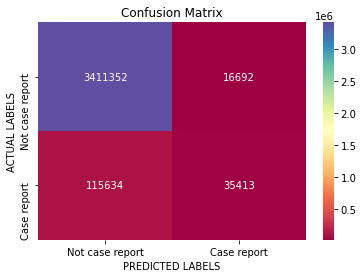

In [128]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
 
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
# cm = [[tp,fp],[fn,tn]]
 
#Plot the matrix
sns.heatmap(cm, annot=True, fmt = "d", cmap="Spectral")
 
# labels, title and ticks
ax.set_ylabel('ACTUAL LABELS')
ax.set_xlabel('PREDICTED LABELS') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not case report','Case report'])
ax.yaxis.set_ticklabels(['Not case report','Case report'])


# Can we find journals which are 100% case-reports?

Obvious strategy - look for journals with case report in the title

In [129]:
case_rep_journals = pubmed[['case report' in str(x).lower() for x in pubmed['journal_title']]].journal_title.unique().tolist()

Strategy 2 - look for journals with high % case reports

In [130]:
casereports = pubmed[(pubmed['articletype1']=='D002363|Case Reports')|(pubmed['articletype2']=='D002363|Case Reports')]
casereports.shape

(151180, 18)

In [131]:
pm_vc = pubmed.journal_title.value_counts()
pm_vc

Scientific reports                                                                              57311
PloS one                                                                                        47242
International journal of molecular sciences                                                     18768
The Science of the total environment                                                            18747
Nature communications                                                                           16541
                                                                                                ...  
Clinics of surgery                                                                                  1
Inventions (Basel, Switzerland)                                                                     1
Family & community history : journal of the Family and Community Historical Research Society        1
Journal for nature conservation                                                   

In [132]:
cr_vc = casereports.journal_title.value_counts()
cr_vc

Cureus                                                         4908
BMJ case reports                                               4797
Medicine                                                       3452
World neurosurgery                                             2227
Clinical case reports                                          1380
                                                               ... 
Geriatrie et psychologie neuropsychiatrie du vieillissement       1
European heart journal. Quality of care & clinical outcomes       1
Clinical implant dentistry and related research                   1
The Libyan journal of medicine                                    1
HIV medicine                                                      1
Name: journal_title, Length: 3687, dtype: int64

In [133]:
jnames = []
for jname in cr_vc.index.tolist():
    count = cr_vc[jname]
    if count>30: # arbitrary number - just want large journals.
        pubmed_count = pm_vc[jname]
        if 0.9*pubmed_count<=count:
            jnames.append(jname)
case_rep_candidates = [x for x in jnames if x not in set(case_rep_journals)]

In [134]:
# how big are they?
cr_vc[case_rep_candidates]

CASE (Philadelphia, Pa.)                               231
GMS ophthalmology cases                                 83
European journal of pediatric surgery reports           78
JBJS case connector                                     78
Journal of oral and maxillofacial pathology : JOMFP     60
The Thoracic and cardiovascular surgeon reports         44
Journal of neurological surgery reports                 37
Clinical nephrology. Case studies                       35
Name: journal_title, dtype: int64

In [135]:
# get a set of case report ISSNs
cr_issns = list(set(pubmed[pubmed['journal_title'].isin(set(jnames))]['journal_issn'].tolist()))
len(cr_issns)

55

In [136]:
pubmed[pubmed['journal_issn'].isin(set(cr_issns))].shape

(12168, 18)

## Next - can we get a -ve class?
- look at SAGE journals which do not accept case reports
  - SMO 2050-3121
  - SCO (for +ve classes) 2051-313X
  - OED (mixed - avoid) 2515-8414
  - TAR 1753-4666
  - TAN 1756-2864
  - TCT 1533-0338 / 1533-0346
  - CCX 1073-2748

In [137]:
non_case_report_issns = {'2050-3121', '1753-4666', '1756-2864', '1533-0338', '1533-0346', '1073-2748'}
pubmed[pubmed['journal_issn'].isin(non_case_report_issns)].shape

(712, 18)

In [138]:
non_case_report_issns = ['2050-3121', '1753-4666', '1756-2864', '1533-0338', '1533-0346', '1073-2748']
for x in non_case_report_issns:
    print(x,pubmed[pubmed['journal_issn']==x].shape)

2050-3121 (446, 18)
1753-4666 (0, 18)
1756-2864 (0, 18)
1533-0338 (266, 18)
1533-0346 (0, 18)
1073-2748 (0, 18)


In [139]:
## ASIDE: lets save these for testing later
pubmed[pubmed['journal_issn'].isin(non_case_report_issns)].to_csv('real_world_data.csv', index = False)

### Above didn't work. Try just taking a random sample for now

In [140]:
## balanced set for now. No real need to do this. 
casereports = pubmed[pubmed['journal_issn'].isin(set(cr_issns))] 


In [141]:
casereports.head(2)

,title,articletitle,abstract,year,articledate,doi,pmid,pii,pmc,articletype1,articletype2,articletype3,journal_title,journal_issn,journal_iso,case_report,tiabs,baseline
1407,Radiology case reports,Tension pneumothorax in patient with COVID-19 ...,Corona-virus infection that arose from China i...,2021,2020-12-02,10.1016/j.radcr.2020.11.044,33288986,S1930-0433(20)30620-8,PMC7709726,D002363|Case Reports,NaN,NaN,Radiology case reports,1930-0433,Radiol Case Rep,1,Tension pneumothorax in patient with COVID-19 ...,0
1408,Radiology case reports,Fatal pulmonary fibrosis complicating COVID-19...,Only a few earlier clinical radiologic reports...,2021,2020-12-02,10.1016/j.radcr.2020.11.050,33288987,S1930-0433(20)30626-9,PMC7709725,D002363|Case Reports,NaN,NaN,Radiology case reports,1930-0433,Radiol Case Rep,1,Fatal pulmonary fibrosis complicating COVID-19...,0


## Filter reviews in case-report journals

In [142]:
casereports['articletype2'].value_counts()

D016428|Journal Article              78
D016425|Published Erratum            35
D016454|Review                        7
D016420|Comment                       5
D016440|Retraction of Publication     2
D002363|Case Reports                  1
D016441|Retracted Publication         1
Name: articletype2, dtype: int64

In [143]:
casereports['articletype1'].value_counts()

D002363|Case Reports         11936
D016428|Journal Article        166
D016425|Published Erratum       34
D016421|Editorial               30
D016433|News                     1
D016417|Bibliography             1
Name: articletype1, dtype: int64

In [144]:
# filter out non-case-report articles
casereports = casereports[casereports['articletype1']=='D002363|Case Reports']
casereports = casereports[casereports['articletype2']!='D016454|Review']
casereports.shape

(11936, 18)

In [145]:
# filter out any missing abstracts and titles
casereports = casereports[[len(str(row['articletitle']))>10 for i,row in casereports.iterrows()]] 
casereports = casereports[[len(str(row['abstract']))>50 for i,row in casereports.iterrows()]] 
casereports.shape

(10934, 18)

In [146]:
# # Use this cell to explore articles with certain text in the title/abstract
# # Think this shows that some literature reviews are being published in case-report journals without being labelled as such
# for k, rw in casereports[[any(any(y in str(x).lower() and 'case' not in str(x).lower() for y in ['systematic review','literature review'])
#                               for x in [row['articletitle']]) #,row['abstract']])
#             for i,row in casereports.iterrows()]].iterrows():
#     print(rw['doi'])
#     print(rw['articletitle'])
#     print(rw['abstract'])
#     print()

# create -ve class

In [147]:
# notice that I lose noncasereports at a faster rate due to filtering below
# therefore adding 1.1* in order to account for that. We don't need to have balanced classes here
# it would be better to have data that 
noncasereports = pubmed[~pubmed['journal_issn'].isin(set(cr_issns))].sample(int(1.1*casereports.shape[0]), random_state = 100)
noncasereports.shape

(12027, 18)

In [148]:
# text processing

In [149]:
casereports = casereports.sample(casereports.shape[0], random_state =7)
noncasereports = noncasereports.sample(noncasereports.shape[0], random_state =7)
casereports['tiabs'] = casereports['articletitle'] + '. ' + casereports['abstract']
noncasereports['tiabs'] = noncasereports['articletitle'] + '. ' + noncasereports['abstract']
casereports['casereport'] = 1
noncasereports['casereport'] = 0


index1 = int(0.8*casereports.shape[0])
index2 = int(0.1*casereports.shape[0])

training_case_reports = casereports.iloc[:index1]
dev_case_reports = casereports.iloc[index1:index1+index2]
test_case_reports = casereports.iloc[index1+index2:]

index1 = int(0.8*noncasereports.shape[0])
index2 = int(0.1*noncasereports.shape[0])

training_non_case_reports = noncasereports.iloc[:index1]
dev_non_case_reports = noncasereports.iloc[index1:index1+index2]
test_non_case_reports = noncasereports.iloc[index1+index2:]


train = pd.concat([training_non_case_reports, training_case_reports])
dev = pd.concat([dev_non_case_reports, dev_case_reports])
test = pd.concat([test_non_case_reports, test_case_reports])

train = train[['doi','articletitle', 'abstract', 'tiabs','casereport']]
dev = dev[['doi','articletitle', 'abstract', 'tiabs','casereport']]
test = test[['doi','articletitle', 'abstract', 'tiabs','casereport']]


train.shape, dev.shape, test.shape

((18368, 5), (2295, 5), (2298, 5))

## cleaning and checking
- remove na
- remove duplicates

In [150]:
train = train.dropna()
dev = dev.dropna()
test = test.dropna()
train.shape, test.shape, dev.shape

((16975, 5), (2166, 5), (2140, 5))

In [151]:
train = train.drop_duplicates(subset=['doi'])
dev = dev.drop_duplicates(subset=['doi'])
test = test.drop_duplicates(subset=['doi'])
train.shape, test.shape, dev.shape

((16974, 5), (2166, 5), (2140, 5))

## check

In [152]:
train.casereport.value_counts(),test.casereport.value_counts(),dev.casereport.value_counts()

(1    8746
 0    8228
 Name: casereport, dtype: int64,
 1    1094
 0    1072
 Name: casereport, dtype: int64,
 1    1093
 0    1047
 Name: casereport, dtype: int64)

In [153]:
train.to_csv(os.path.join(working_data_path, 'train.csv'), index = False)
dev.to_csv(os.path.join(working_data_path, 'dev.csv'), index=False)
test.to_csv(os.path.join(working_data_path, 'test.csv'), index=False)

In [154]:
train.head()

,doi,articletitle,abstract,tiabs,casereport
516856,10.1007/s10388-020-00767-0,Preoperative computed tomography predicts the ...,Recurrent laryngeal nerve paralysis (RLNP) aft...,Preoperative computed tomography predicts the ...,0
1847544,10.1167/19.7.2,Dynamic combination of position and motion inf...,"To accurately foveate a moving target, the ocu...",Dynamic combination of position and motion inf...,0
1616444,10.1111/papr.12837,Opiate Intoxication Caused by Epidural Infusio...,Epidural infusion of local anesthetics with op...,Opiate Intoxication Caused by Epidural Infusio...,0
2920682,10.1016/j.prp.2018.05.007,Extraneuraxial hemangioblastoma: A clinicopath...,Less than 250 extraneuraxial hemangioblastomas...,Extraneuraxial hemangioblastoma: A clinicopath...,0
1830535,10.3390/jcm8070957,Glycyrrhizin Protects the Diabetic Retina agai...,"Damage associated molecular pattern (DAMPs), s...",Glycyrrhizin Protects the Diabetic Retina agai...,0


In [155]:
dev.head()

,doi,articletitle,abstract,tiabs,casereport
1761346,10.1021/acs.jpcb.9b04746,Characterization of Protein-Facilitated Ion-Tr...,Protein electrochemistry studies at a polarize...,Characterization of Protein-Facilitated Ion-Tr...,0
891530,10.2215/CJN.15611219,AKI!Now Initiative: Recommendations for Awaren...,The American Society of Nephrology has establi...,AKI!Now Initiative: Recommendations for Awaren...,0
2170107,10.1097/MD.0000000000014447,The role of robotic gait training and tDCS in ...,Friedrich ataxia (FA) is the most common inher...,The role of robotic gait training and tDCS in ...,0
1889123,10.1016/j.jvoice.2019.04.017,Granular Cell Tumors of the Larynx: A Clinicop...,Granular cell tumors (GCT) are uncommon neopla...,Granular Cell Tumors of the Larynx: A Clinicop...,0
1449242,10.5588/ijtld.18.0382,Relationship between smoking and spontaneously...,SETTING: The Korea National Health and Nutriti...,Relationship between smoking and spontaneously...,0


In [156]:
from tools import pre_s
s = dev['tiabs'].tolist()[0]
s, pre_s(s)


('Characterization of Protein-Facilitated Ion-Transfer Mechanism at a Polarized Aqueous/Organic Interface.. Protein electrochemistry studies at a polarized interface between two immiscible electrolyte solutions (ITIES) indicate that the detection mechanism of a protein at the interface involves a combination of protein-anion complexation and interfacial adsorption processes. A detailed characterization of the protein-facilitated mechanism of ion transfer at the ITIES will allow the development of new label-free biomolecular detection tools. Molecular dynamics simulations were performed to describe the mechanism of transfer of the hydrophobic anion tetraphenylborate (TPB-) from a 1,2-dichloroethane (organic) phase to an aqueous phase mediated by lysozyme as a model protein under the action of an external electric field. The anion migrated to the protein at the interface and formed multiple contacts. The side chains of positively charged Lys and Arg residues formed electrostatic interact